`RandomList` is a class that helps to select an entry from a weighted random list. It is used to select Gaussian clusters from Gaussian mixture.

In [3]:
from typing import TypeVar, Generic, List, Final

T = TypeVar('T')


class WeightedEntry(Generic[T]):

    def __init__(self, weight: float, data: T):
        self.weight: Final = weight
        self.data: Final = data


class RandomList(Generic[T]):

    def __init__(self):
        self.list: List[WeightedEntry[T]] = []
        self.sum_weight = 0

    def add_entry(self, weight: float, obj: T):
        if weight <= 0:
            raise AssertionError("invalid weight: " + str(weight))
        self.list.append(WeightedEntry(weight, obj))
        self.sum_weight += weight

    def get_random_entry(self, rand_number: float):
        if rand_number < 0 or rand_number > 1 or len(self.list) == 0 or self.sum_weight <= 0:
            raise AssertionError("invalid list")
        rand_number *= self.sum_weight
        for entry in self.list:
            rand_number -= entry.weight
            if rand_number < 0:
                return entry.data
        raise AssertionError("failed to find entry")


`GaussianVariable` represents one Gaussian cluster. It receievs mean and A matrix, where A times transpose of A equals to the covariance.
- `sample_data`: function to give a random vector that follows the distribution represented by this cluster
- `get_density`: get the value of density function at one location

`GaussianMixture` represents one Gaussian mixture. It is a weighted random list of Gaussian clusters.
- `get_random_data` gives an array of sample data generated according to the distribution of this mixture
- `get_density` provides the value of density function represented by this mixture

In [4]:
import numpy as np
import math


class GaussianVariable(object):

    def __init__(self, n: int, mean: np.ndarray, a: np.ndarray):
        self.n = n
        self.mean = mean
        self.a = a
        if mean.shape != (n,):
            raise AssertionError("mean dimension mismatch")
        if a.shape != (n, n):
            raise AssertionError("cov dimension mismatch")

    def sample_data(self):
        iid = np.random.standard_normal((self.n,))
        return self.mean + np.matmul(self.a, iid)

    def get_density(self, data: np.ndarray):
        c = np.matmul(self.a, np.transpose(self.a))
        x = data - self.mean
        coef = math.pow(2 * math.pi * np.linalg.det(c), -1 / 2)
        expm = -np.matmul(np.matmul(x, np.linalg.inv(c)), np.transpose(x)) / 2
        return coef * math.exp(expm)


class GaussianMixture(RandomList[GaussianVariable]):

    def __init__(self, n: int):
        super().__init__()
        self.n = n

    def add_gaussian(self, weight: float, mean: np.ndarray, a: np.ndarray):
        self.add_entry(weight, GaussianVariable(self.n, mean, a))

    def get_random_data(self, size: int, seed: int = 0):
        np.random.seed(seed)
        choice = np.random.random((size,))
        return np.asarray([self.get_random_entry(val).sample_data() for val in choice], np.single)

    def get_density(self, data: np.ndarray):
        chance = 0
        for entry in self.list:
            chance += entry.weight * entry.data.get_density(data)
        return chance


### Problem 0
`a_from_eigen_angle` generates the A matrix from eigen values and angle of eigen vectors
Then I construct the mixtures, collect samples, and plot them. Blue dots are the class 0 points, and orange dots are the class 1 points.

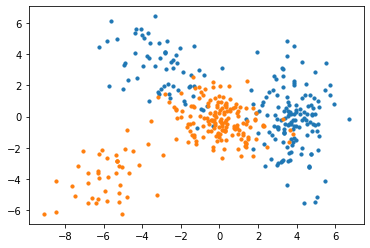

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

def a_from_eigen_angle(eig_1, eig_2, theta):
    eig_vector = np.transpose(np.array([[math.cos(theta), math.sin(theta)], 
            [-math.sin(theta), math.cos(theta)]]))
    eig_value = np.diag([math.sqrt(eig_1), math.sqrt(eig_2)])
    return np.matmul(eig_vector, eig_value)

mixture_0 = GaussianMixture(2)
mixture_0.add_gaussian(2 / 3, np.array([4, 0]), 
        a_from_eigen_angle(1, 4, 0))
mixture_0.add_gaussian(1 / 3, np.array([-3, 3]), 
        a_from_eigen_angle(1, 4, math.pi / 4))
sample_0 = mixture_0.get_random_data(200, 0)
plt.scatter(sample_0[:, 0], sample_0[:, 1],s=10)


mixture_1 = GaussianMixture(2)
mixture_1.add_gaussian(3 / 4, np.array([0, 0]), 
        a_from_eigen_angle(1, 2, math.pi / 3))
mixture_1.add_gaussian(1 / 4, np.array([-6, -4]), 
        a_from_eigen_angle(2, 1, math.pi / 4))
sample_1 = mixture_1.get_random_data(200, 0)
plt.scatter(sample_1[:, 0], sample_1[:, 1],s=10)


Here I create a 500x500 mesh grid, and fill with the difference of PDF of two mixtures. Positive value means it represents areas that will be classified as class 1 by MAP. Negative value means it represents areas that will be classified as class 0 by MAP.

In [4]:
gran = 500
X, Y = np.meshgrid(np.linspace(-10, 10, gran), np.linspace(-10, 10, gran))
Z = np.zeros((gran,gran))
for i in range(gran):
    for j in range(gran):
        Z[i,j] = mixture_1.get_density(np.array([X[i,j],Y[i,j]]))-mixture_0.get_density(np.array([X[i,j],Y[i,j]]))



Then I classify the sample data based on MAP. 

Blue region is the region classified as class 0 by MAP. 

Orange region is the region classified as class 1 by MAP. 

White dots are the sample data points that are classified correctly. 

Blue x's are the sample data points that are from class 0 but classified as class 1.

Orange x's are the sample data points that are from class 1 but classified as class 0.

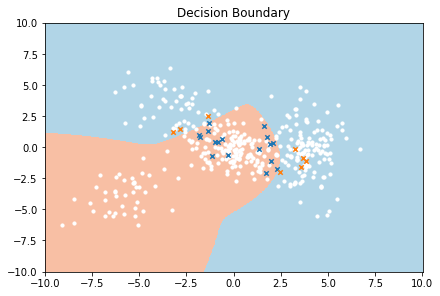

In [ ]:
W = np.sign(Z)*0.3
fig, axs = plt.subplots(1, 1, layout='constrained')
pc = axs.pcolormesh(X, Y, W, vmin=-1, vmax=1, cmap='RdBu_r')
axs.set_title('Decision Boundary')

c0a = [mixture_0.get_density(sample_0[i])>mixture_1.get_density(sample_0[i]) for i in range(200)]
c0b = [not c0a[i] for i in range(200)]

c1a = [mixture_1.get_density(sample_1[i])>mixture_0.get_density(sample_1[i]) for i in range(200)]
c1b = [not c1a[i] for i in range(200)]
plt.scatter(sample_0[c0a, 0], sample_0[c0a, 1], s = 10, c='#ffffff',marker='o')
plt.scatter(sample_1[c1a, 0], sample_1[c1a, 1], s = 10,c='#ffffff',marker='o')
plt.scatter(sample_0[c0b, 0], sample_0[c0b, 1], s = 20, c='#1f77b4',marker='x')
plt.scatter(sample_1[c1b, 0], sample_1[c1b, 1], s = 20,c='#ff7f0e',marker='x')

### Problem 3
Here I collect 100k sample data to calculate the rate of misclassification.

In [5]:
n = 100000

map_sample_0 = mixture_0.get_random_data(n, 0)
map_sample_1 = mixture_1.get_random_data(n, 0)
test_sample_0 = mixture_0.get_random_data(n, 12345)
test_sample_1 = mixture_1.get_random_data(n, 12345)

In [436]:

err_0 = 0
err_1 = 0
for i in range(n):
    if mixture_1.get_density(test_sample_0[i]) > mixture_0.get_density(test_sample_0[i]):
        err_0 += 1
    if mixture_0.get_density(test_sample_1[i]) > mixture_1.get_density(test_sample_1[i]):
        err_1 += 1
print(err_0, err_1)

8562 5803


Thus, we can know that the error probabilities are 8.41% and 5.88% respectively.

In [6]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

class Net(nn.Module):

    def __init__(self, n_in, n_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = F.relu(x)
        x = self.fc2.forward(x)
        return x

    def initialize(self, func):
        func(self.fc1.weight)
        func(self.fc1.bias)
        func(self.fc2.weight)
        func(self.fc2.bias)



In [114]:
def gen_sample(data_0, data_1, n, preprocess = False):
    ans = torch.from_numpy(np.concatenate((data_0[0:n, :], data_1[0:n, :])))
    if preprocess:
        ans = (ans - torch.mean(ans,0)) / torch.std(ans,0)
    return ans

def train(n_sample, l2_lambda, lrate, net, eps, test_n = -1, preprocess = False, initializer = None):
    if test_n < 0:
        test_n = n_sample
    if initializer == None:
        initializer = lambda a:torch.nn.init.normal_(a,0,1e-1)
    optimizer = optim.Adam(net.parameters(), lr=lrate)
    optimizer.zero_grad()
    criterion = nn.BCEWithLogitsLoss()
    data = gen_sample(map_sample_0, map_sample_1, n_sample, preprocess)
    test = gen_sample(test_sample_0, test_sample_1, test_n, preprocess)
    label = torch.from_numpy(np.concatenate((np.zeros((n_sample,), np.single),np.ones((n_sample,), np.single)))).view([n_sample*2,1])
    net.initialize(initializer)

    list_lv = []
    list_lvr = []
    list_lr0 = []
    list_lr1 = []
    list_ac0 = []
    list_ac1 = []
    prev = 1e3
    lv = 1e2
    while abs(prev-lv) > lv*eps:
        prev = lv

        output = net.forward(data)

        lr_0 = int(torch.count_nonzero(output.data[0:n_sample] >= 0))/n_sample
        lr_1 = int(torch.count_nonzero(output.data[n_sample:-1] <= 0))/n_sample

        loss = criterion(output, label)
        lv = loss.item()
        l2_norm = sum(p.pow(2).sum() for p in net.parameters())
        loss = loss + l2_lambda * l2_norm
        lvr = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        list_lv.append(lv)
        list_lvr.append(lvr)

        output = net.forward(test)
        ac_0 = int(torch.count_nonzero(output.data[0:test_n] >= 0))/test_n
        ac_1 = int(torch.count_nonzero(output.data[test_n:-1] <= 0))/test_n
        list_lr0.append(lr_0)
        list_lr1.append(lr_1)
        list_ac0.append(ac_0)
        list_ac1.append(ac_1)

    return {"net":net ,"lv":list_lv, "lvr":list_lvr, "lr0":list_lr0, "lr1":list_lr1, "ac0":list_ac0, "ac1":list_ac1}



def train_H1(n_sample, l2_lambda, lrate, neurons, eps, test_n = -1, preprocess = False, initializer = None):
    net = Net(2, neurons)
    return train(n_sample, l2_lambda, lrate, net, eps, test_n, preprocess, initializer)


In [119]:
def plotasc(axs: List[plt.Axes], model):

    list_lv = model["lv"]
    list_lvr = model["lvr"]
    list_ac0 = model["ac0"]
    list_ac1 = model["ac1"]
    list_ac = (np.array(list_ac0)+np.array(list_ac1))/2

    axs[0].plot(list_lv)
    axs[0].set_title('loss')
    axs[0].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss Value')
    axs[1].plot(list_ac)
    axs[1].set_ylim(0,1)
    axs[1].set_title('error')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Error Rate')

    return min(list_ac)


[0.073475, 0.073625, 0.0738, 0.07325, 0.0731, 0.07367499999999999]


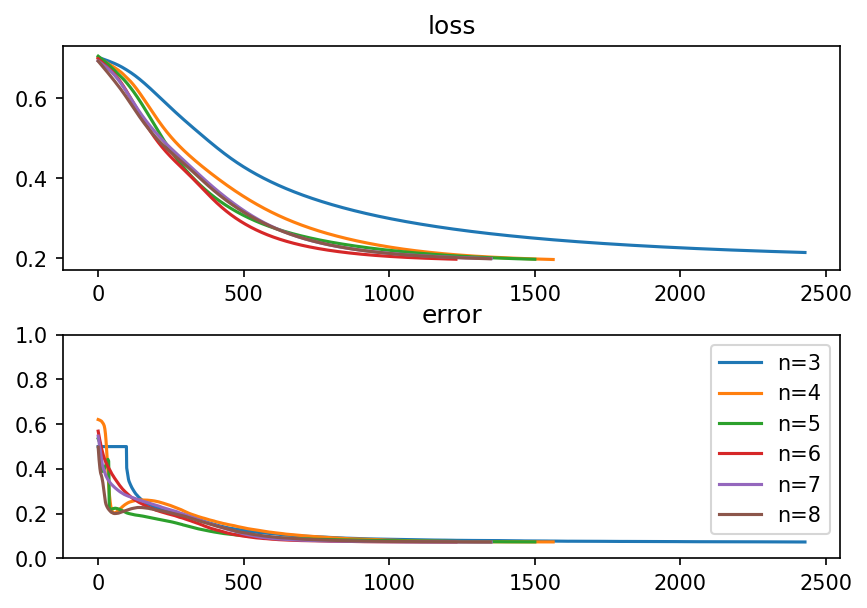

In [368]:
fig, axs = plt.subplots(2, 1, dpi=150)
plt.tight_layout()
vals = [
    plotasc(axs, n03me4),
    plotasc(axs, n04me4),
    plotasc(axs, n05me4),
    plotasc(axs, n06me4),
    plotasc(axs, n07me4),
    plotasc(axs, n08me4)]
axs[1].legend(['n=3','n=4','n=5','n=6','n=7','n=8','n=16'])
print(vals)

In [8]:
def plot_lr(model, axs, n, title, transparency):
    samp_0 = test_sample_0[0:n, :]
    samp_1 = test_sample_1[0:n, :]

    output = model['net'].forward(torch.tensor(np.array([X,Y])).type(torch.FloatTensor).permute(1,2,0))
    

    ZL = np.zeros((gran, gran))
    for i in range(gran):
        for j in range(gran):
            ZL[i, j] = output[i][j]
    WL = np.sign(ZL)*0.3
    pc = axs.pcolormesh(X, Y, WL, vmin=-1, vmax=1, cmap='RdBu_r')
    axs.set_title(title, size=10)
    axs.set_aspect('equal', 'box')

    c0 = model['net'].forward(torch.tensor(samp_0).type(torch.FloatTensor))
    c1 = model['net'].forward(torch.tensor(samp_1).type(torch.FloatTensor))

    c0a = [c0[i].item() < 0 for i in range(n)]
    c0b = [not c0a[i] for i in range(n)]

    c1a = [c1[i].item() > 0 for i in range(n)]
    c1b = [not c1a[i] for i in range(n)]
    axs.scatter(samp_0[c0a, 0], samp_0[c0a, 1], s=0.5,
                c='#ffffff', marker='o', alpha=transparency)
    axs.scatter(samp_1[c1a, 0], samp_1[c1a, 1], s=0.5,
                c='#ffffff', marker='o', alpha=transparency)
    axs.scatter(samp_0[c0b, 0], samp_0[c0b, 1], s=0.5, c='#1f77b4', marker='x')
    axs.scatter(samp_1[c1b, 0], samp_1[c1b, 1], s=0.5, c='#ff7f0e', marker='x')




In [ ]:
gran = 100
X, Y = np.meshgrid(np.linspace(-10, 10, gran), np.linspace(-10, 10, gran))
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(n03me4, axs[0][0], 200, 'n=3',1)
plot_lr(n04me4, axs[0][1], 200, 'n=4',1)
plot_lr(n05me4, axs[0][2], 200, 'n=5',1)
plot_lr(n06me4, axs[1][0], 200, 'n=6',1)
plot_lr(n07me4, axs[1][1], 200, 'n=7',1)
plot_lr(n08me4, axs[1][2], 200, 'n=8',1)

In [442]:
n04lr1 = train_H1(20000, 1e-3, 1e-4, 4,  1e-6)
n04lr2 = train_H1(20000, 1e-3, 3e-4, 4,  1e-5)
n04lr3 = train_H1(20000, 1e-3, 1e-3, 4,  1e-4)
n04lr4 = train_H1(20000, 1e-3, 3e-3, 4,  1e-4)
n04lr5 = train_H1(20000, 1e-3, 1e-2, 4,  1e-4)
n04lr6 = train_H1(20000, 1e-3, 3e-2, 4,  1e-4)

In [405]:
n04l1 = train_H1(20000, 1e-4, 1e-3, 4, 1e-4)
n04l2 = train_H1(20000, 1e-3, 1e-3, 4, 1e-4)
n04l3 = train_H1(20000, 1e-2, 1e-3, 4, 1e-4)
n04l4 = train_H1(20000, 1e-1, 1e-3, 4, 1e-4)
n04l5 = train_H1(20000, 1e0 , 1e-3, 4, 1e-4)
n04l6 = train_H1(20000, 1e1 , 1e-3, 4, 1e-4)

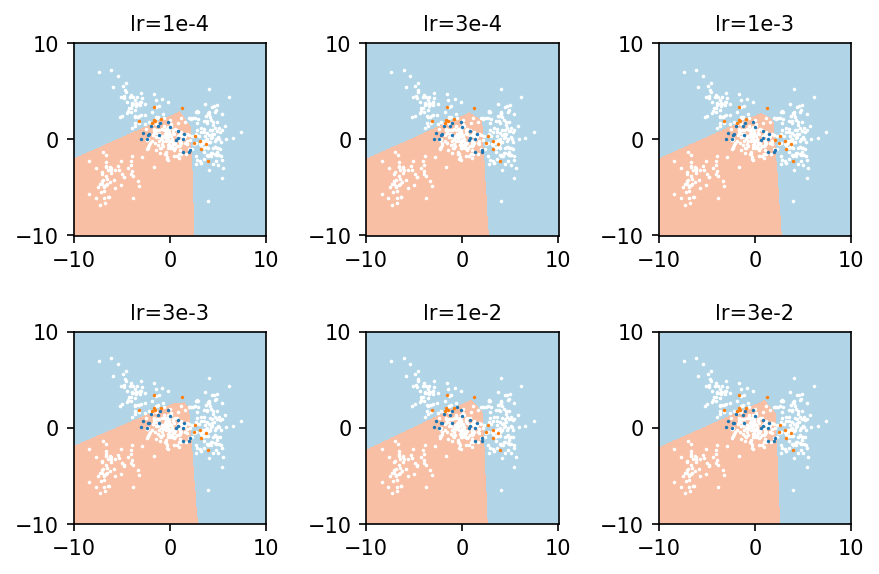

In [443]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(n04lr1, axs[0][0], 200, 'lr=1e-4',1)
plot_lr(n04lr2, axs[0][1], 200, 'lr=3e-4',1)
plot_lr(n04lr3, axs[0][2], 200, 'lr=1e-3',1)
plot_lr(n04lr4, axs[1][0], 200, 'lr=3e-3',1)
plot_lr(n04lr5, axs[1][1], 200, 'lr=1e-2',1)
plot_lr(n04lr6, axs[1][2], 200, 'lr=3e-2',1)

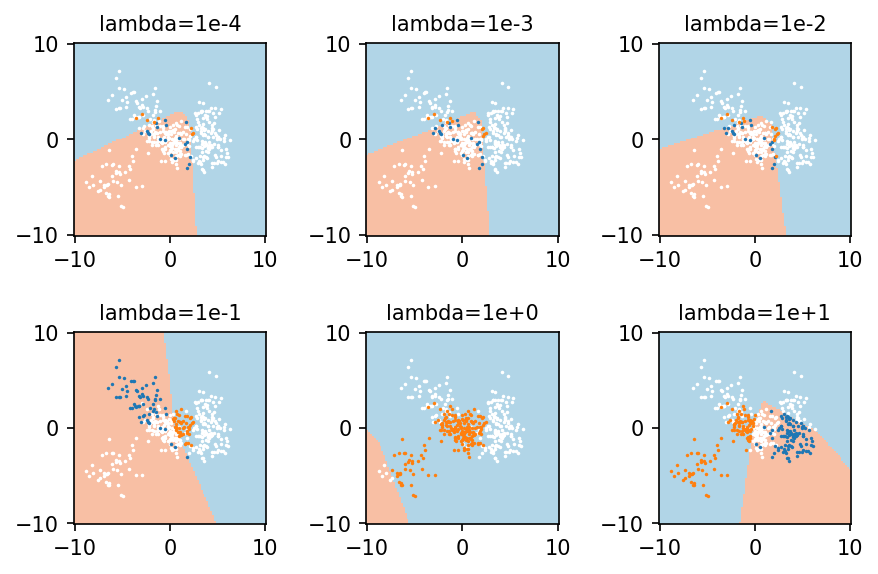

In [406]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(n04l1, axs[0][0], 200, 'lambda=1e-4',1)
plot_lr(n04l2, axs[0][1], 200, 'lambda=1e-3',1)
plot_lr(n04l3, axs[0][2], 200, 'lambda=1e-2',1)
plot_lr(n04l4, axs[1][0], 200, 'lambda=1e-1',1)
plot_lr(n04l5, axs[1][1], 200, 'lambda=1e+0',1)
plot_lr(n04l6, axs[1][2], 200, 'lambda=1e+1',1)

In [421]:
n04s1 = train_H1(20000, 1e-3, 1e-3, 4, 1e-4)
n04s2 = train_H1(6000, 1e-3, 1e-3, 4, 1e-4)
n04s3 = train_H1(2000, 1e-3, 1e-3, 4, 1e-4)
n04s4 = train_H1(600, 1e-3, 1e-3, 4, 1e-4)
n04s5 = train_H1(200, 1e-3, 1e-3, 4, 1e-4)
n04s6 = train_H1(60, 1e-3, 1e-3, 4, 1e-4)

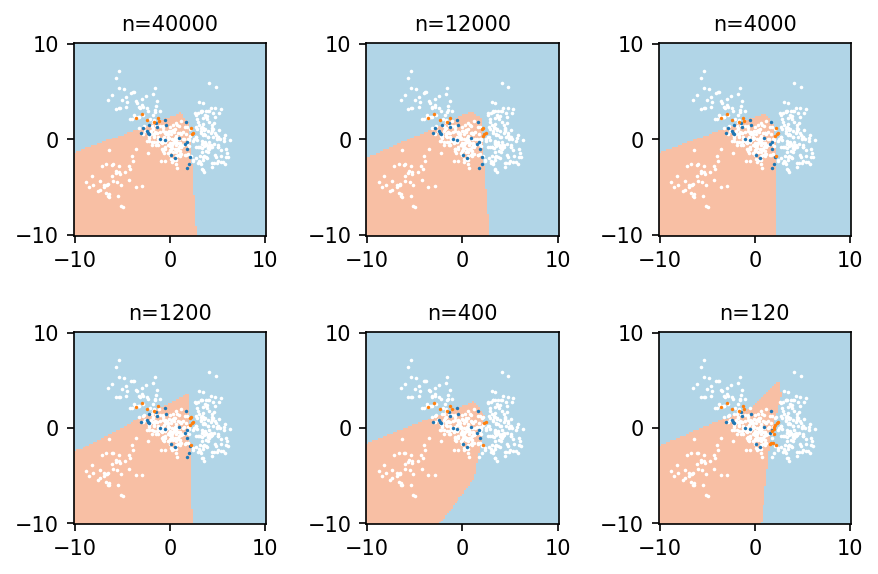

In [427]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(n04s1, axs[0][0], 200, 'n=40000',1)
plot_lr(n04s2, axs[0][1], 200, 'n=12000',1)
plot_lr(n04s3, axs[0][2], 200, 'n=4000',1)
plot_lr(n04s4, axs[1][0], 200, 'n=1200',1)
plot_lr(n04s5, axs[1][1], 200, 'n=400',1)
plot_lr(n04s6, axs[1][2], 200, 'n=120',1)

In [445]:
models = [[n01me4,n02me4,n03me4,n04me4,n05me4,n06me4,n07me4,n08me4],
[n04lr1,n04lr2,n04lr3,n04lr4,n04lr5,n04lr6],
[n04l1,n04l2,n04l3,n04l4,n04l5,n04l6],
[n04s1,n04s2,n04s3,n04s4,n04s5,n04s6]]


In [446]:
test = gen_sample(test_sample_0, test_sample_1, n)

for l in models:
    for m in l:
        net = m["net"]
        output = net.forward(test)
        ac0 = int(torch.count_nonzero(output.data[0:n] >= 0))/n
        ac1 = int(torch.count_nonzero(output.data[n:-1] <= 0))/n
        print('ac0 = ',ac0,', ac1 = ',ac1, 'avg, ',(ac0+ac1)/2)
    print('')

ac0 =  1.0 , ac1 =  0.0 avg,  0.5
ac0 =  0.08924 , ac1 =  0.06294 avg,  0.07608999999999999
ac0 =  0.08017 , ac1 =  0.07015 avg,  0.07516
ac0 =  0.08276 , ac1 =  0.06887 avg,  0.075815
ac0 =  0.08333 , ac1 =  0.06817 avg,  0.07575
ac0 =  0.08371 , ac1 =  0.06702 avg,  0.075365
ac0 =  0.08409 , ac1 =  0.06686 avg,  0.075475
ac0 =  0.08444 , ac1 =  0.06692 avg,  0.07568

ac0 =  0.08473 , ac1 =  0.06429 avg,  0.07450999999999999
ac0 =  0.08409 , ac1 =  0.06568 avg,  0.07488500000000001
ac0 =  0.08097 , ac1 =  0.07015 avg,  0.07556
ac0 =  0.0845 , ac1 =  0.06618 avg,  0.07534
ac0 =  0.08487 , ac1 =  0.06404 avg,  0.074455
ac0 =  0.08463 , ac1 =  0.06448 avg,  0.074555

ac0 =  0.08474 , ac1 =  0.06502 avg,  0.07488
ac0 =  0.08301 , ac1 =  0.06848 avg,  0.075745
ac0 =  0.07699 , ac1 =  0.08204 avg,  0.079515
ac0 =  0.33077 , ac1 =  0.22748 avg,  0.279125
ac0 =  0.0 , ac1 =  0.97285 avg,  0.486425
ac0 =  0.47406 , ac1 =  0.59364 avg,  0.5338499999999999

ac0 =  0.08274 , ac1 =  0.06889 avg,  

In [471]:
lrac = train_H1(20000, 1e-3, 1e-3, 4,  1e-4)

(0.0, 1.0)

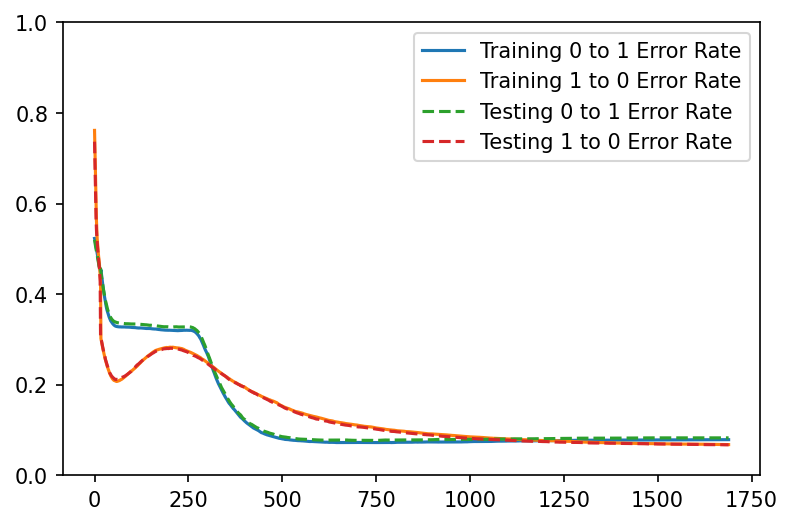

In [472]:
fig, axs = plt.subplots(1, 1, dpi=150)
axs.plot(lrac["lr0"],'-')
axs.plot(lrac["lr1"],'-')
axs.plot(lrac["ac0"],'--')
axs.plot(lrac["ac1"],'--')
axs.legend(labels = ['Training 0 to 1 Error Rate','Training 1 to 0 Error Rate','Testing 0 to 1 Error Rate','Testing 1 to 0 Error Rate'])
axs.set_ylim([0,1])

In [88]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

class Net2(nn.Module):

    def __init__(self, n_in, n1, n2):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(n_in, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, 1)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = F.relu(x)
        x = self.fc2.forward(x)
        x = F.relu(x)
        x = self.fc3.forward(x)
        return x

    def initialize(self, func):
        func(self.fc1.weight)
        func(self.fc1.bias)
        func(self.fc2.weight)
        func(self.fc2.bias)
        func(self.fc3.weight)
        func(self.fc3.bias)

def train_H2(n_sample, l2_lambda, lrate, n1, n2, eps, test_n=-1, preprocess = False, initializer = None):
    net = Net2(2, n1,n2)
    return train(n_sample, l2_lambda, lrate, net, eps, test_n, preprocess, initializer)


In [489]:
n2r_422 = train_H2(20000, 1e-3, 1e-3, 2, 2, 1e-5)
n2r_424 = train_H2(20000, 1e-3, 1e-3, 2, 4, 1e-5)
n2r_442 = train_H2(20000, 1e-3, 1e-3, 4, 2, 1e-5)
n2r_444 = train_H2(20000, 1e-3, 1e-3, 4, 4, 1e-5)
n2r_244 = train_H2(200, 1e-3, 1e-3, 4, 4, 1e-5)

Text(0.5, 1.0, 'MAP')

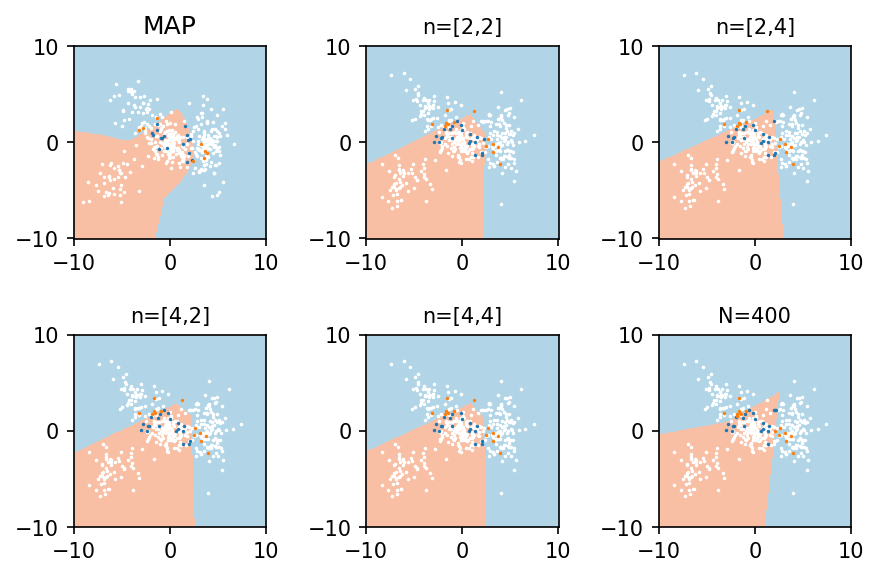

In [497]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(n2r_422, axs[0][1], 200, 'n=[2,2]',1)
plot_lr(n2r_424, axs[0][2], 200, 'n=[2,4]',1)
plot_lr(n2r_442, axs[1][0], 200, 'n=[4,2]',1)
plot_lr(n2r_444, axs[1][1], 200, 'n=[4,4]',1)
plot_lr(n2r_244, axs[1][2], 200, 'N=400',1)

axs[0][0].pcolormesh(X, Y, W, vmin=-1, vmax=1, cmap='RdBu_r')
axs[0][0].set_aspect('equal', 'box')
axs[0][0].scatter(sample_0[c0a, 0], sample_0[c0a, 1], s = 0.5, c='#ffffff',marker='o')
axs[0][0].scatter(sample_1[c1a, 0], sample_1[c1a, 1], s = 0.5,c='#ffffff',marker='o')
axs[0][0].scatter(sample_0[c0b, 0], sample_0[c0b, 1], s = 0.5, c='#1f77b4',marker='x')
axs[0][0].scatter(sample_1[c1b, 0], sample_1[c1b, 1], s = 0.5,c='#ff7f0e',marker='x')
axs[0][0].set_title('MAP')

In [500]:
n2r_lr2 = train_H2(20000, 1e-3, 1e-2, 4, 4, 1e-5)
n2r_l2 = train_H2(20000, 1e-2, 1e-3, 4, 4, 1e-5)
n2r_144 = train_H2(60, 1e-3, 1e-3, 4, 4, 1e-5)

In [501]:
models = [n2r_422,n2r_424,n2r_442,n2r_444,n2r_lr2,n2r_l2,n2r_244,n2r_144]
test = gen_sample(test_sample_0, test_sample_1, n)

for m in models:
    net = m["net"]
    output = net.forward(test)
    ac0 = int(torch.count_nonzero(output.data[0:n] >= 0))/n
    ac1 = int(torch.count_nonzero(output.data[n:-1] <= 0))/n
    print('ac0 = ',ac0,', ac1 = ',ac1, 'avg, ',(ac0+ac1)/2)

ac0 =  0.087 , ac1 =  0.06122 avg,  0.07411
ac0 =  0.08856 , ac1 =  0.06189 avg,  0.075225
ac0 =  0.08671 , ac1 =  0.06239 avg,  0.07455
ac0 =  0.08623 , ac1 =  0.06254 avg,  0.074385
ac0 =  0.08717 , ac1 =  0.05992 avg,  0.073545
ac0 =  0.08271 , ac1 =  0.06917 avg,  0.07594000000000001
ac0 =  0.0 , ac1 =  0.99999 avg,  0.499995
ac0 =  0.08013 , ac1 =  0.07633 avg,  0.07823
ac0 =  0.06377 , ac1 =  0.11346 avg,  0.088615


(0.0, 1.0)

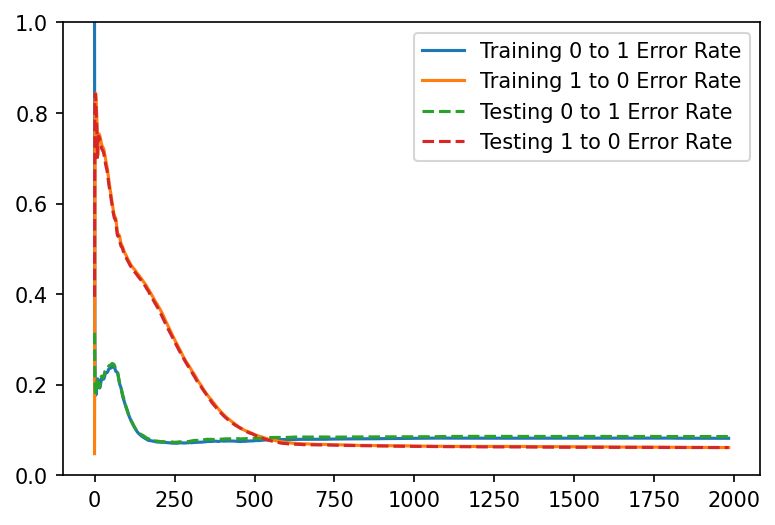

In [504]:
fig, axs = plt.subplots(1, 1, dpi=150)
axs.plot(n2r_444["lr0"],'-')
axs.plot(n2r_444["lr1"],'-')
axs.plot(n2r_444["ac0"],'--')
axs.plot(n2r_444["ac1"],'--')
axs.legend(labels = ['Training 0 to 1 Error Rate','Training 1 to 0 Error Rate','Testing 0 to 1 Error Rate','Testing 1 to 0 Error Rate'])
axs.set_ylim([0,1])

In [37]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

class Net1T(nn.Module):

    def __init__(self, n_in, n):
        super(Net1T, self).__init__()
        self.fc1 = nn.Linear(n_in, n)
        self.fc2 = nn.Linear(n, 1)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = torch.tanh(x)
        x = self.fc2.forward(x)
        return x

    def initialize(self, func):
        func(self.fc1.weight)
        func(self.fc1.bias)
        func(self.fc2.weight)
        func(self.fc2.bias)

class Net2T(nn.Module):

    def __init__(self, n_in, n1, n2):
        super(Net2T, self).__init__()
        self.fc1 = nn.Linear(n_in, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, 1)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = torch.tanh(x)
        x = self.fc2.forward(x)
        x = torch.tanh(x)
        x = self.fc3.forward(x)
        return x

    def initialize(self, func):
        func(self.fc1.weight)
        func(self.fc1.bias)
        func(self.fc2.weight)
        func(self.fc2.bias)
        func(self.fc3.weight)
        func(self.fc3.bias)

def train_1T(n_sample, l2_lambda, lrate, n1, eps, test_n=-1):
    net = Net1T(2, n1)
    return train(n_sample, l2_lambda, lrate, net, eps, test_n)

def train_2T(n_sample, l2_lambda, lrate, n1, n2, eps, test_n=-1):
    net = Net2T(2, n1, n2)
    return train(n_sample, l2_lambda, lrate, net, eps, test_n)

In [12]:
t1n3 = train_1T(20000, 1e-3, 1e-3, 3,  1e-4)
t1n4 = train_1T(20000, 1e-3, 1e-3, 4,  1e-4)
t1n5 = train_1T(20000, 1e-3, 1e-3, 5,  1e-4)
t1n6 = train_1T(20000, 1e-3, 1e-3, 6,  1e-4)
t1n7 = train_1T(20000, 1e-3, 1e-3, 7,  1e-4)
t1n8 = train_1T(20000, 1e-3, 1e-3, 8,  1e-4)
t1r1 = train_1T(20000, 1e-3, 1e-4, 4,  1e-6)
t1r2 = train_1T(20000, 1e-3, 1e-3, 4,  1e-4)
t1r3 = train_1T(20000, 1e-3, 1e-2, 4,  1e-4)
t1l1 = train_1T(20000, 1e-4, 1e-3, 4, 1e-4)
t1l2 = train_1T(20000, 1e-3, 1e-3, 4, 1e-4)
t1l3 = train_1T(20000, 1e-2, 1e-3, 4, 1e-4)
t1l4 = train_1T(20000, 1e-1, 1e-3, 4, 1e-4)
t1s1 = train_1T(20000, 1e-3, 1e-3, 4, 1e-4)
t1s2 = train_1T(6000, 1e-3, 1e-3, 4, 1e-4)
t1s3 = train_1T(2000, 1e-3, 1e-3, 4, 1e-4)
t1s4 = train_1T(600, 1e-3, 1e-3, 4, 1e-4)
t1s5 = train_1T(200, 1e-3, 1e-3, 4, 1e-4)
t1s6 = train_1T(60, 1e-3, 1e-3, 4, 1e-4)

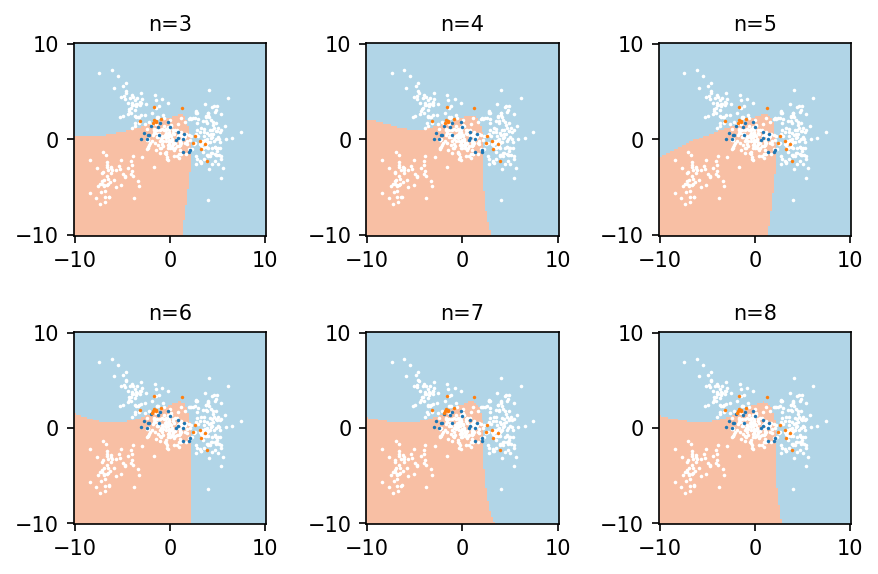

In [20]:

fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(t1n3, axs[0][0], 200, 'n=3',1)
plot_lr(t1n4, axs[0][1], 200, 'n=4',1)
plot_lr(t1n5, axs[0][2], 200, 'n=5',1)
plot_lr(t1n6, axs[1][0], 200, 'n=6',1)
plot_lr(t1n7, axs[1][1], 200, 'n=7',1)
plot_lr(t1n8, axs[1][2], 200, 'n=8',1)

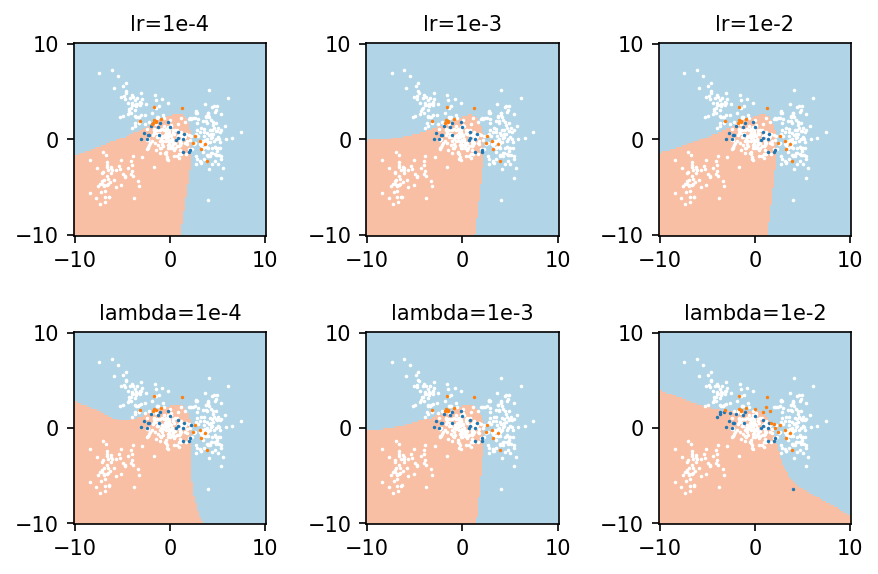

In [21]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(t1r1, axs[0][0], 200, 'lr=1e-4',1)
plot_lr(t1r2, axs[0][1], 200, 'lr=1e-3',1)
plot_lr(t1r3, axs[0][2], 200, 'lr=1e-2',1)
plot_lr(t1l1, axs[1][0], 200, 'lambda=1e-4',1)
plot_lr(t1l2, axs[1][1], 200, 'lambda=1e-3',1)
plot_lr(t1l3, axs[1][2], 200, 'lambda=1e-2',1)

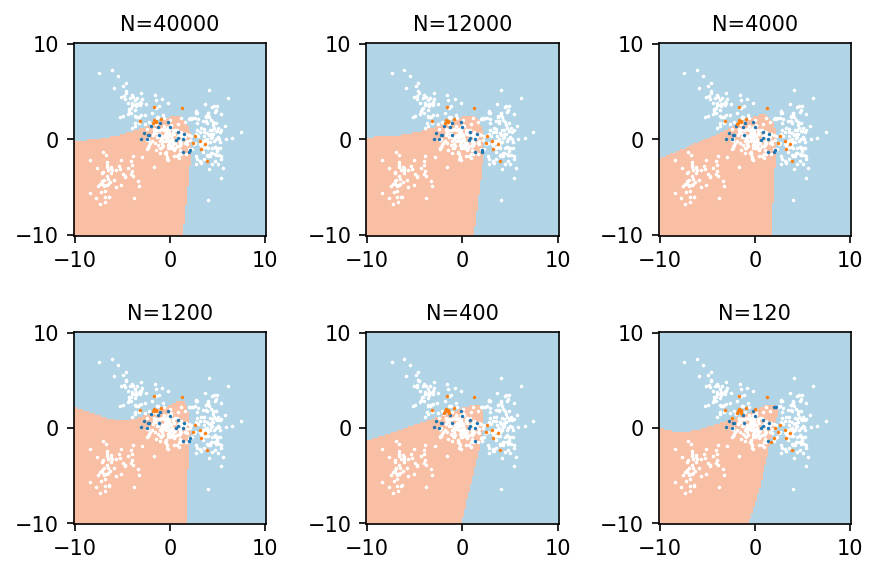

In [23]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(t1s1, axs[0][0], 200, 'N=40000',1)
plot_lr(t1s2, axs[0][1], 200, 'N=12000',1)
plot_lr(t1s3, axs[0][2], 200, 'N=4000',1)
plot_lr(t1s4, axs[1][0], 200, 'N=1200',1)
plot_lr(t1s5, axs[1][1], 200, 'N=400',1)
plot_lr(t1s6, axs[1][2], 200, 'N=120',1)

In [24]:
t2r_422 = train_2T(20000, 1e-3, 1e-3, 2, 2, 1e-5)
t2r_424 = train_2T(20000, 1e-3, 1e-3, 2, 4, 1e-5)
t2r_442 = train_2T(20000, 1e-3, 1e-3, 4, 2, 1e-5)
t2r_444 = train_2T(20000, 1e-3, 1e-3, 4, 4, 1e-5)
t2r_244 = train_2T(200, 1e-3, 1e-3, 4, 4, 1e-5)
t2r_lr2 = train_2T(20000, 1e-3, 1e-2, 4, 4, 1e-5)
t2r__l2 = train_2T(20000, 1e-2, 1e-3, 4, 4, 1e-5)
t2r_144 = train_2T(60, 1e-3, 1e-3, 4, 4, 1e-5)

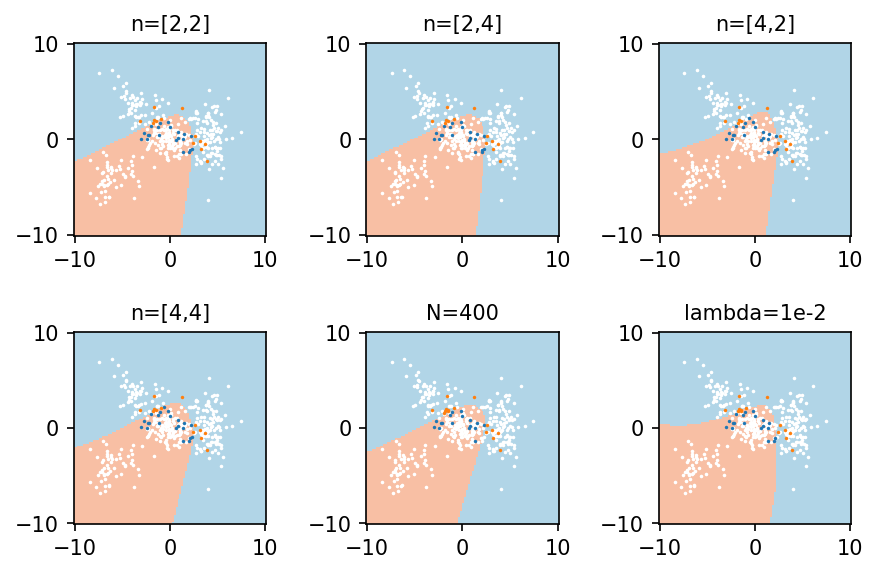

In [27]:
fig, axs = plt.subplots(2, 3, dpi=150)
plt.tight_layout()
plot_lr(t2r_422, axs[0][0], 200, 'n=[2,2]',1)
plot_lr(t2r_424, axs[0][1], 200, 'n=[2,4]',1)
plot_lr(t2r_442, axs[0][2], 200, 'n=[4,2]',1)
plot_lr(t2r_444, axs[1][0], 200, 'n=[4,4]',1)
plot_lr(t2r_244, axs[1][1], 200, 'N=400',1)
plot_lr(t2r__l2, axs[1][2], 200, 'lambda=1e-2',1)

In [28]:
models = [t1n3,t1n4,t1n5,t1n6,t1n7,t1n8,t1r1,t1r2,t1r3,t1l1,t1l2,t1l3,t1l4,t1s1,t1s2,t1s3,t1s4,t1s5,t1s6]
test = gen_sample(test_sample_0, test_sample_1, n)

for m in models:
    net = m["net"]
    output = net.forward(test)
    ac0 = int(torch.count_nonzero(output.data[0:n] >= 0))/n
    ac1 = int(torch.count_nonzero(output.data[n:-1] <= 0))/n
    print('ac0 = ',ac0,', ac1 = ',ac1, 'avg, ',(ac0+ac1)/2)

ac0 =  0.08353 , ac1 =  0.06747 avg,  0.0755
ac0 =  0.08349 , ac1 =  0.06793 avg,  0.07571
ac0 =  0.08004 , ac1 =  0.06927 avg,  0.074655
ac0 =  0.08049 , ac1 =  0.0683 avg,  0.074395
ac0 =  0.08108 , ac1 =  0.06768 avg,  0.07438
ac0 =  0.0798 , ac1 =  0.06876 avg,  0.07428
ac0 =  0.08151 , ac1 =  0.06562 avg,  0.07356499999999999
ac0 =  0.0814 , ac1 =  0.06757 avg,  0.074485
ac0 =  0.08168 , ac1 =  0.06608 avg,  0.07388
ac0 =  0.08574 , ac1 =  0.06393 avg,  0.074835
ac0 =  0.08137 , ac1 =  0.06838 avg,  0.074875
ac0 =  0.09961 , ac1 =  0.09438 avg,  0.096995
ac0 =  0.19379 , ac1 =  0.30695 avg,  0.25037
ac0 =  0.08079 , ac1 =  0.06888 avg,  0.074835
ac0 =  0.08251 , ac1 =  0.06723 avg,  0.07486999999999999
ac0 =  0.07859 , ac1 =  0.07033 avg,  0.07446
ac0 =  0.07872 , ac1 =  0.0721 avg,  0.07541
ac0 =  0.06843 , ac1 =  0.09037 avg,  0.0794
ac0 =  0.05724 , ac1 =  0.1219 avg,  0.08957


In [29]:
models = [t2r_422,t2r_424,t2r_442,t2r_444,t2r_244,t2r_lr2,t2r__l2,t2r_144]
test = gen_sample(test_sample_0, test_sample_1, n)

for m in models:
    net = m["net"]
    output = net.forward(test)
    ac0 = int(torch.count_nonzero(output.data[0:n] >= 0))/n
    ac1 = int(torch.count_nonzero(output.data[n:-1] <= 0))/n
    print('ac0 = ',ac0,', ac1 = ',ac1, 'avg, ',(ac0+ac1)/2)

ac0 =  0.0862 , ac1 =  0.0616 avg,  0.0739
ac0 =  0.08586 , ac1 =  0.06201 avg,  0.073935
ac0 =  0.08511 , ac1 =  0.06057 avg,  0.07284
ac0 =  0.0843 , ac1 =  0.06156 avg,  0.07293
ac0 =  0.07185 , ac1 =  0.08342 avg,  0.077635
ac0 =  0.0847 , ac1 =  0.06108 avg,  0.07289
ac0 =  0.08055 , ac1 =  0.07174 avg,  0.07614499999999999
ac0 =  0.05598 , ac1 =  0.12902 avg,  0.0925


Text(0.5, 1.0, '2 layers')

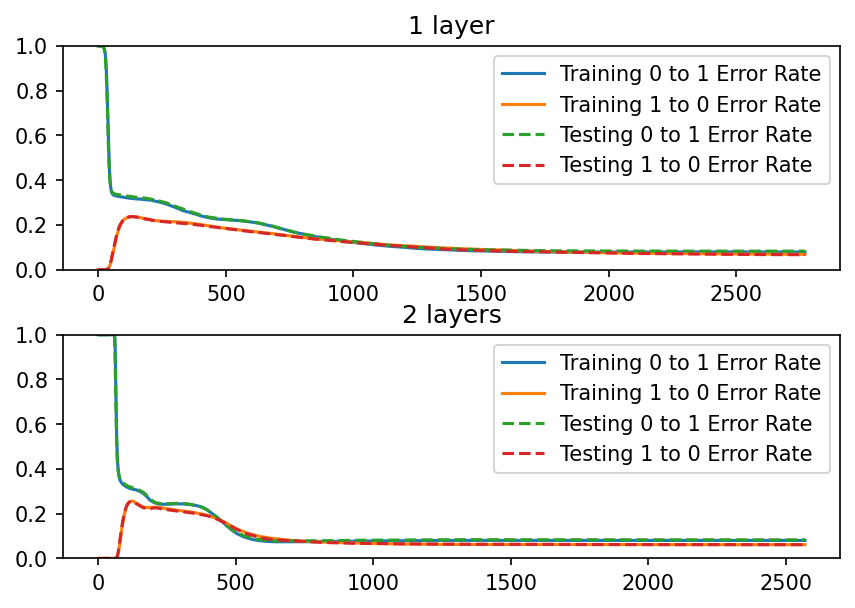

In [33]:

fig, axs = plt.subplots(2, 1, dpi=150)
plt.tight_layout()
axs[0].plot(t1n4["lr0"],'-')
axs[0].plot(t1n4["lr1"],'-')
axs[0].plot(t1n4["ac0"],'--')
axs[0].plot(t1n4["ac1"],'--')
axs[0].legend(labels = ['Training 0 to 1 Error Rate','Training 1 to 0 Error Rate','Testing 0 to 1 Error Rate','Testing 1 to 0 Error Rate'])
axs[0].set_ylim([0,1])
axs[0].set_title('1 layer')
axs[1].plot(t2r_444["lr0"],'-')
axs[1].plot(t2r_444["lr1"],'-')
axs[1].plot(t2r_444["ac0"],'--')
axs[1].plot(t2r_444["ac1"],'--')
axs[1].legend(labels = ['Training 0 to 1 Error Rate','Training 1 to 0 Error Rate','Testing 0 to 1 Error Rate','Testing 1 to 0 Error Rate'])
axs[1].set_ylim([0,1])
axs[1].set_title('2 layers')








In [47]:
h1n60 = train_H1(60, 1e-3, 1e-3, 4, 1e-4, 100000)
h2n60 = train_H2(60, 1e-3, 1e-3, 4, 4, 1e-5,100000)
t1n60 = train_1T(60, 1e-3, 1e-3, 4, 1e-4,100000)
t2n60 = train_2T(60, 1e-3, 1e-3, 4, 4, 1e-5,100000)

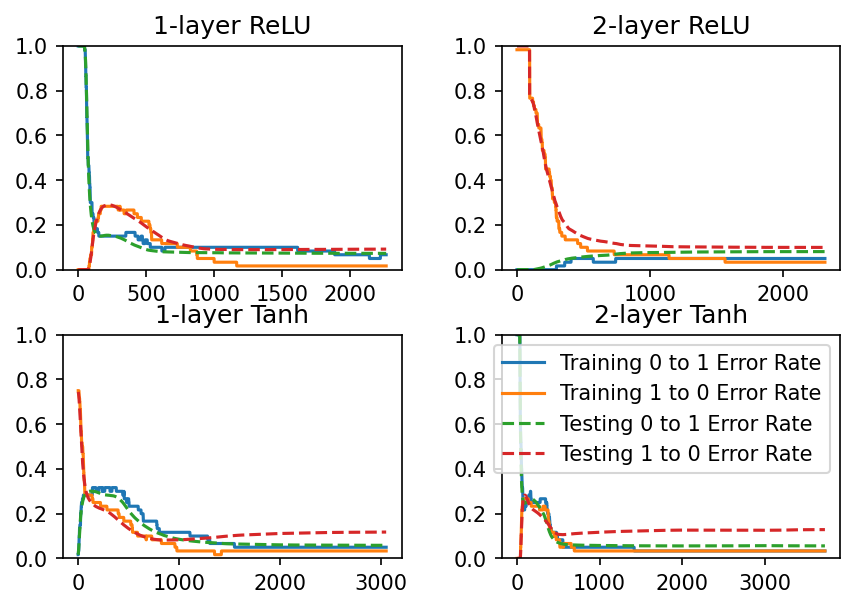

In [48]:
def plot_sm(axs, model, title):
    axs.plot(model["lr0"],'-')
    axs.plot(model["lr1"],'-')
    axs.plot(model["ac0"],'--')
    axs.plot(model["ac1"],'--')
    axs.set_ylim([0,1])
    axs.set_title(title)


fig, axs = plt.subplots(2, 2, dpi=150)
plt.tight_layout()
plot_sm(axs[0][0], h1n60, '1-layer ReLU')
plot_sm(axs[0][1], h2n60, '2-layer ReLU')
plot_sm(axs[1][0], t1n60, '1-layer Tanh')
plot_sm(axs[1][1], t2n60, '2-layer Tanh')
plt.legend(labels = ['Training 0 to 1 Error Rate','Training 1 to 0 Error Rate','Testing 0 to 1 Error Rate','Testing 1 to 0 Error Rate'])



In [115]:
h1np= train_H1(20000, 1e-3, 1e-3, 4, 1e-4, 20000, False, None)
h1pr= train_H1(20000, 1e-3, 1e-3, 4, 1e-4, 20000, True, None)

[0.07525, 0.07585]


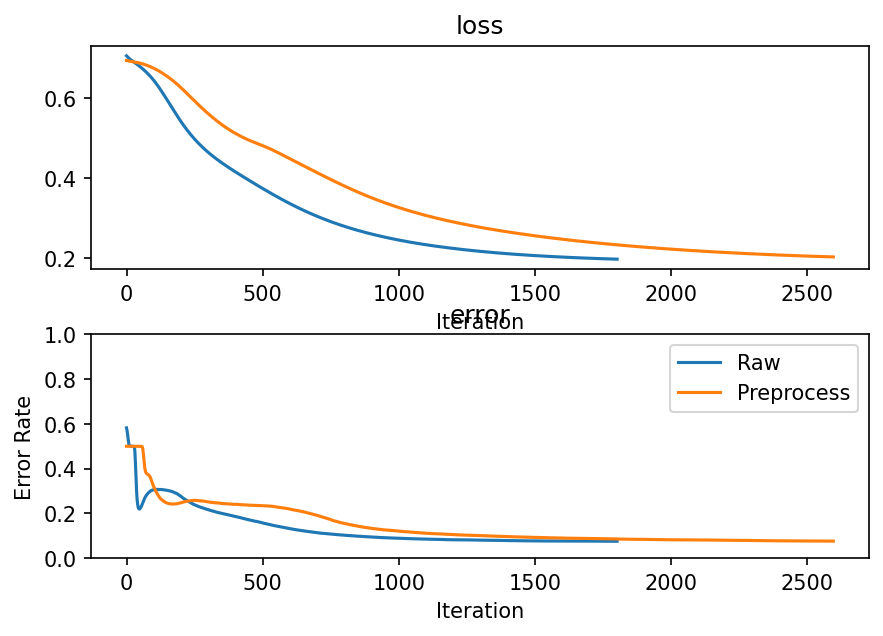

In [120]:
fig, axs = plt.subplots(2, 1, dpi=150)
plt.tight_layout()
vals = [
    plotasc(axs, h1np),
    plotasc(axs, h1pr)]
axs[1].legend(['Raw','Preprocess'])
print(vals)

In [79]:
h1n01= train_H1(20000, 1e-3, 1e-3, 4, 1e-4, 20000, False, lambda a:torch.nn.init.normal_(a,0,1e-1))
h1n11= train_H1(20000, 1e-3, 1e-3, 4, 1e-4, 20000, False, lambda a:torch.nn.init.normal_(a,1e-1,1e-1))
h1u0= train_H1(20000, 1e-3, 1e-3, 4, 1e-4, 20000, False, lambda a:torch.nn.init.uniform_(a,0))
h1u1= train_H1(20000, 1e-3, 1e-3, 4, 1e-4, 20000, False, lambda a:torch.nn.init.uniform_(a,1e-1))

[0.075375, 0.074575, 0.07585, 0.076725]


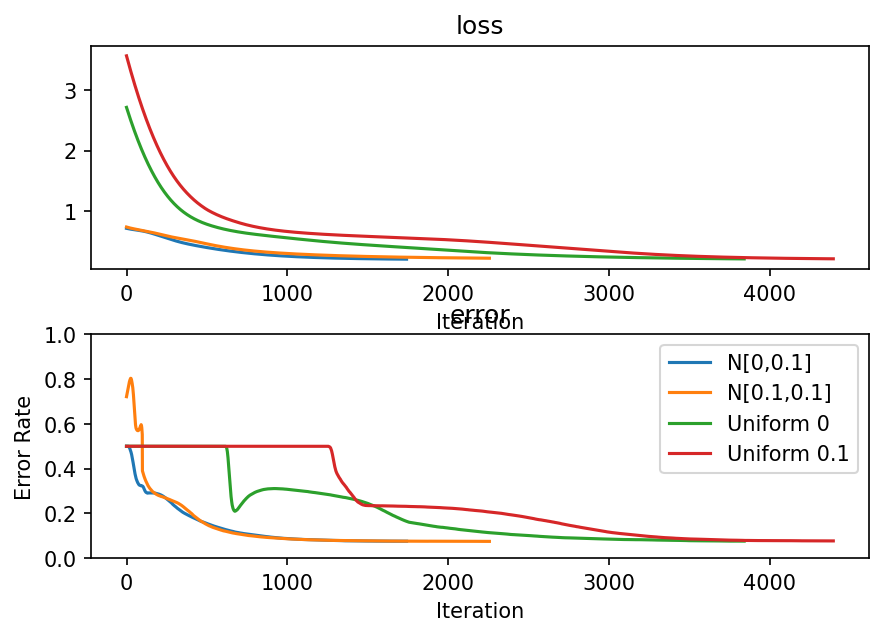

In [121]:
fig, axs = plt.subplots(2, 1, dpi=150)
plt.tight_layout()
vals = [
    plotasc(axs, h1n01),
    plotasc(axs, h1n11),
    plotasc(axs, h1u0),
    plotasc(axs, h1u1)]
axs[1].legend(['N[0,0.1]','N[0.1,0.1]','Uniform 0','Uniform 0.1'])
print(vals)

In [89]:
h44n01= train_H2(20000, 1e-3, 1e-3, 4, 4, 1e-4, 20000, False, lambda a:torch.nn.init.normal_(a,0,1e-1))
h44n02= train_H2(20000, 1e-3, 1e-3, 4, 4, 1e-4, 20000, False, lambda a:torch.nn.init.normal_(a,0,2e-1))
h22n01= train_H2(20000, 1e-3, 1e-3, 2, 2, 1e-4, 20000, False, lambda a:torch.nn.init.normal_(a,0,1e-1))
h22n02= train_H2(20000, 1e-3, 1e-3, 2, 2, 1e-4, 20000, False, lambda a:torch.nn.init.normal_(a,0,2e-1))

tensor([1.1625, 0.7970])